# Фильтр Калмана 
*Хромов Алексей*

## Одномерный случай

### Теория

Фильтр "Калмана" используют для фильтрации зашумленного сигнала. Модель сиглана обычно считается известа.
Фильтр Калмана основан на параметрическом g-h фильтре.

#### Пердсказание

К примеру, рассмотрим одномерное движение с начальной коордиинатой $x_0$ и скоростью $v$,  тогда модель выглядит сдеующим образом:
$$ x=x_0+vt\\ $$
Пусть мы имеем какую-то модель для сигнала и можем с какой-то вероятнотсью предсказывать следующие значния $\bar{x}_k$ из предыдущих $x_{k-1}$, тогда наша модель примет следущий вид:

$$ \begin{aligned} \bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$

Наша модель очень проста, но мы не можем быть уверены в её правильности. Покажем нашу неуверенность через функции Гаусса:
$$\begin{gathered}
x=\mathcal N(\mu_x, \sigma_x^2)\\
f_x = \mathcal N (\mu_{f_x}, \sigma_{f_x}^2)
\end{gathered}$$
Теперь наша модель выглядит как:
$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 \end{aligned}$$
Сразу бросаетсся в глаза рост ошибки с каждым новым предсказанием. Действительно, ведь мы теряем информацию из-за неуверенности нашей модели, поэтому дисперсия постоянно растет.
 

#### Обновление

Теперь мы имеем два занчения:
- предсказанное с какой-то вероятностью значение $\bar \mu$
- зашумленное значение из сигнала $\mu_z$

Нам необходимо "выбрать" наивероятнейшее значение с учетом отклонений: 
$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$
Перепишем нашее выражение: 
$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$
И сделаем замену:

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$
где $K$ - коэффициент са
$$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$

Коэффициент или вес филтра Калмана несет в себе вероятносстную ошибку, то есть он показывает, чему мы больше склонны доверять, нашей неточной модели или значнию зашумленного сигнала.

#### Вывод
Соберём теперь все вместе. 
- Сначала мы делаем прогноз будущего значения, на основе уже имеющихся данных
- Далее выбираем значение из сигнала
- В конце формирует новую оценку выбирая что-то между предсказанием и опытом

### Алгоритм фильтра Калмана

**Инициализация**

    1. Инициализируем начальные данные и состояние фильтра 
    2. Инициализируем вероятностные состояния, ошибки
    
**Прогнозирование**

    1. Прогнозируем состояние системы на следующем временном шаге, используя характеристики модели
    2. Вычисляем вероятность нашего прогноза, ошибку
    
**Обновление**

    1. Получаем измерение и ее точность
    2. Вычисляем невязку между расчетным состоянем и измерением
    3. Вычисляем коэффициент масштабирования 
    4. Выбираем состояние между прогнозом и измерением на основе масштабного коэффициента
    5. Обновляем вероятностную ошибку выбранного состояния

<u>Прогнозирование</u>

$\begin{array}{|l|l|l|}
\hline
\text{Реализация} & \text{Калмановская форма}\\
\hline
\bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
\bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>Обновление</u>

$\begin{array}{|l|l|l|}
\hline
\text{Реализация}& \text{Калмановская форма}\\
\hline
y = z - \bar\mu & y = z - \bar x\\
K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
\mu = \bar \mu + Ky & x = \bar x + Ky\\
\sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$
### Реализация

Подключение библиотек и форматов для подсчета, построения графиков, рандома и Гаусса.

In [1]:
from __future__ import division, print_function
%matplotlib inline

import book_format
book_format.set_style()

import numpy as np
import random
import matplotlib.pyplot as plt


from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

from ipywidgets import interact

Функция получения сигнала и зашумленного сигнала.

In [2]:
def signal(value, std, k):
    return value + ((random.randrange(0,2+k)-k) * std)


def signal_noise(value, std):
    return value + (random.uniform(-1,1) * std)

Наши фунции предсказания и обновеления

In [3]:
def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

In [4]:

from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])

In [5]:
def model(change, sensor_var, process_var, initial, N, k):
    
    x = gaussian(0, 1000.) # initial state
    process_model = gaussian(change, process_var)
    
    #N = 50
    z_orig = [initial]
    z_noise = [signal_noise(initial, sensor_var)]
    ps = []
    estimates = []
    predic = []
    
    
    for i in range(N):
        z_orig.append(signal(z_orig[i], change, k))
        z_noise.append(signal_noise(z_orig[i], sensor_var))
        
    
    for z in z_noise:
        prior = predict(x, process_model)
        x = update(prior, gaussian(z, sensor_var))
    
        # save for latter plotting
        estimates.append(x.mean)
        ps.append(x.var)
        predic.append(prior.mean)
        
    
        
    # plot the filter output and the variance
    book_plots.plot_measurements(z_noise)
    book_plots.plot_predictions(predic)
    plt.plot(z_orig, label='Original signal', color='r')
    book_plots.plot_filter(estimates, var=np.array(ps))
    book_plots.show_legend()
    #plt.ylim(5, 10)
    book_plots.set_labels(x='step', y='signal')
    plt.show()
        
    plt.plot(ps)
    plt.title('Variance')
    print('Variance converges to {:.3f}'.format(ps[-1]))
    




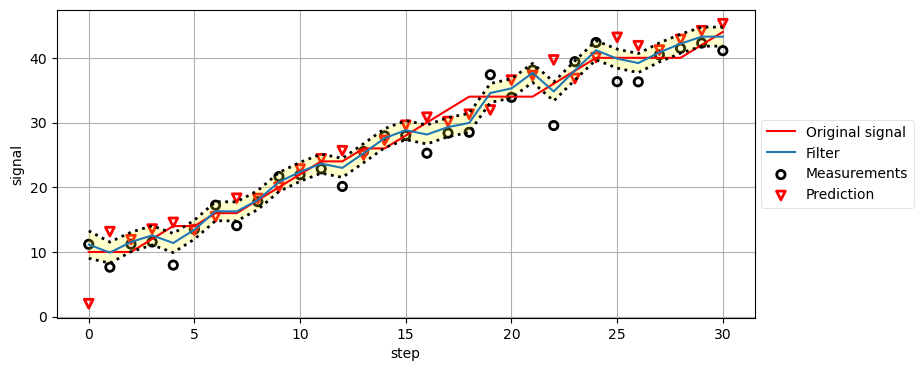

Variance converges to 2.162


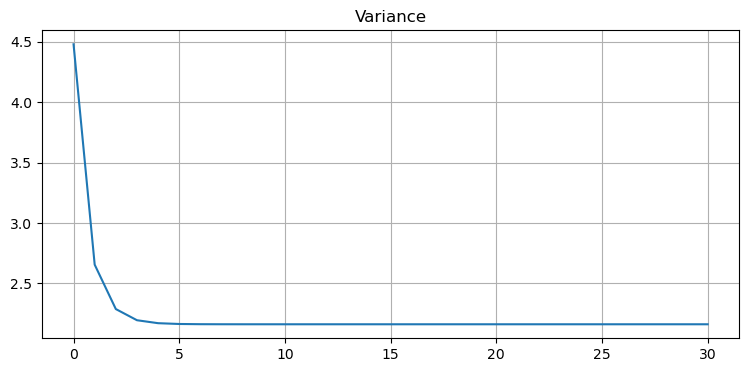

In [8]:
#interact(model,
#         change = (0., 10., 1), #step of the model
#         sensor_var = (0., 100., 1), #noise
#         process_var = (0., 10., 1), #device error
#         initial = (0., 20., 2),  #initial coordinate of the model
#         N = (0, 40, 5),
#         k = (0,1,1));  #random speed sign (if k==0 then speed_>0(onle))

change = 2.0 #step of the model
sensor_var = 4.5 #noise
process_var = 2 #device error
initial = 10  #initial coordinate of the model
N = 30
k = 0  #random speed sign {if k==0 then speed_>=0 (onle)}  {if k==1 then speed_>=0 || speed_<0 (onle)}




model(change, sensor_var, process_var, initial, N, k)

## Многомерный случай

### Алгоритм фильтра Калмана

#### Пердсказание

$\begin{array}{|l|l|l|}
\hline
\text{Многомерный случай}\\
\hline
\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$


$\mathbf x,\, \mathbf P$ это среднее значение и ковариационная матрица.

$\mathbf F$ функция перехода.

$\mathbf Q$ это процесс ковариации.

$\mathbf B$ и $\mathbf u$ динамические входы.

**Обновление**

$\begin{array}{|l|l|l|}
\hline
\text{Многомерный случай}\\
\hline
\mathbf y = \mathbf z - \mathbf{H\bar x} \\
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ измеряющая функция.

$\mathbf z,\, \mathbf R$ это среднее значение и ковариация шума. 

$\mathbf y$ и $\mathbf K$ это невязка и матрица Калмана.